<a href="https://colab.research.google.com/github/AnabelleSouza/CRUD_PDO-CONTEINER/blob/main/wine_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exercício 2


In [2]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets

# metadata
print(wine_quality.metadata)

# variable information
print(wine_quality.variables)


{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

In [4]:
import pandas as pd
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pymc as pm
import numpy as np
import arviz as az



In [5]:
# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Separar dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import arviz as az


def analise_priori(trace, y):
    fig, axes = plt.subplots(3, 2, figsize=(10, 10), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

    # Acessar os valores dos betas a partir do grupo 'prior'
    betas_values = trace.prior['betas'].values.flatten()  # Acessa os betas do grupo 'prior' e achata
    sns.histplot(betas_values, bins=20, kde=True, ax=axes[0][0])
    axes[0][0].set_xlabel("Betas")
    axes[0][0].set_ylabel("Contagem")

    # Histograma para as previsões da variável dependente (priors)
    y_obs_values = trace.prior_predictive['Y_obs'].values.flatten()  # Acessa as previsões a priori de Y_obs
    sns.histplot(y_obs_values, bins=20, kde=True, ax=axes[0][1])
    axes[0][1].set_xlabel("Previsões a Priori (Y_obs)")
    axes[0][1].set_ylabel("Contagem")

    # Previsões a priori
    prior_samples = trace.prior_predictive['Y_obs'].values  # Acessa os valores de Y_obs a partir da distribuição preditiva
    prior_samples_reshaped = prior_samples.reshape(len(y), -1)

    # Cálculo da média e desvio padrão das previsões a priori
    mean_pred = np.mean(prior_samples_reshaped, axis=1)
    std_pred = np.std(prior_samples_reshaped, axis=1)

    # Plotar as previsões médias a priori
    sns.lineplot(x=range(len(y)), y=mean_pred, ax=axes[1][0])
    axes[1][0].fill_between(range(len(y)), mean_pred - std_pred, mean_pred + std_pred, alpha=0.2)

    axes[1][0].set_title("Previsões a Priori")
    axes[1][0].set_xlabel("Observado")
    axes[1][0].set_ylabel("Previsões")
    axes[1][0].legend(['Previsões Médias'])

    # Gráficos cumulativos da priori usando Arviz
    az.plot_ppc(trace, group='prior', kind='cumulative', ax=axes[2][0], observed=True)
    az.plot_ppc(trace, group='prior', ax=axes[2][1], observed=True)

    plt.tight_layout()
    return fig, axes

RIDGE

In [7]:
import pymc as pm
import arviz as az
import pytensor.tensor as pt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Certificar que y tenha a forma correta
y = np.array(y).reshape(-1)  # Garante que y seja um vetor unidimensional

# Definir as coordenadas do modelo (quantidade de features)
coords = {'features': np.arange(X_scaled.shape[1])}

# Criar o modelo Ridge Bayesiano
with pm.Model(coords=coords) as model_ridge:
    # Priori para o intercepto (alpha)
    alpha = pm.Normal('alpha', mu=0, sigma=10)

    # Priori para os coeficientes de regressão (betas)
    betas = pm.Normal('betas', mu=0, sigma=10, dims='features')

    # Priori para o desvio padrão do erro (epsilon)
    epsilon = pm.Gamma('epsilon', alpha=2, beta=1)  # Gamma prior para epsilon

    # Definir a equação do modelo linear
    mu = alpha + pt.dot(X_scaled, betas)  # Substituir tt.dot por pt.dot

    # Definir a verossimilhança (Normal)
    likelihood = pm.Normal('Y_obs', mu=mu, sigma=epsilon, observed=y)

    # Amostrar da distribuição a priori (para análise a priori)
    ridge_trace_prior = pm.sample_prior_predictive()

    # Amostrar da distribuição posterior (para ajuste do modelo)
    trace_ridge = pm.sample(1000, tune=1000, target_accept=0.95)

# Exibir o resumo dos parâmetros ajustados

az.summary(trace_ridge)

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,5.818,0.009,5.802,5.837,0.000,0.000,2215.0,1435.0,1.0
betas[0],0.088,0.020,0.050,0.124,0.001,0.000,1039.0,1255.0,1.0
betas[1],-0.218,0.012,-0.240,-0.196,0.000,0.000,1412.0,1361.0,1.0
betas[2],-0.016,0.011,-0.036,0.005,0.000,0.000,1657.0,1508.0,1.0
betas[3],0.207,0.024,0.163,0.252,0.001,0.001,863.0,1027.0,1.0
betas[4],-0.017,0.012,-0.039,0.004,0.000,0.000,1874.0,1628.0,1.0
betas[5],0.106,0.014,0.082,0.131,0.000,0.000,1594.0,1033.0,1.0
betas[6],-0.140,0.016,-0.169,-0.109,0.000,0.000,1321.0,1266.0,1.0
betas[7],-0.165,0.035,-0.233,-0.101,0.001,0.001,823.0,880.0,1.0
betas[8],0.070,0.014,0.044,0.096,0.000,0.000,1076.0,1236.0,1.0


In [8]:
# Amostrar da distribuição posterior preditiva
posterior_predictive = pm.sample_posterior_predictive(trace_ridge, model=model_ridge)

 # Imprimir as chaves do posterior_predictive
print(posterior_predictive.keys())


Output()

KeysView(Inference data with groups:
	> posterior_predictive
	> observed_data)


In [9]:
# Verificar as chaves do posterior_predictive
print(posterior_predictive['posterior_predictive'].keys())

# Verificar as chaves do observed_data
print(posterior_predictive['observed_data'].keys())

KeysView(<xarray.Dataset> Size: 104MB
Dimensions:      (chain: 2, draw: 1000, Y_obs_dim_2: 6497)
Coordinates:
  * chain        (chain) int64 16B 0 1
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * Y_obs_dim_2  (Y_obs_dim_2) int64 52kB 0 1 2 3 4 ... 6492 6493 6494 6495 6496
Data variables:
    Y_obs        (chain, draw, Y_obs_dim_2) float64 104MB 4.806 4.111 ... 6.678
Attributes:
    created_at:                 2024-09-24T16:32:58.764790+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2)
KeysView(<xarray.Dataset> Size: 104kB
Dimensions:      (Y_obs_dim_0: 6497)
Coordinates:
  * Y_obs_dim_0  (Y_obs_dim_0) int64 52kB 0 1 2 3 4 ... 6492 6493 6494 6495 6496
Data variables:
    Y_obs        (Y_obs_dim_0) float64 52kB 5.0 5.0 5.0 6.0 ... 5.0 6.0 7.0 6.0
Attributes:
    created_at:                 2024-09-24T16:32:58.769919+00:00
    arviz_version:              0.19.0
    inference_librar

In [10]:
# Acessar dados preditivos de Y_obs
y_obs_pred = posterior_predictive['posterior_predictive']['Y_obs']
print(y_obs_pred)

# Cálculo da média ou outras estatísticas
y_obs_mean = y_obs_pred.mean(axis=0)
print(y_obs_mean)


<xarray.DataArray 'Y_obs' (chain: 2, draw: 1000, Y_obs_dim_2: 6497)> Size: 104MB
array([[[4.80622458, 4.1111751 , 5.28701868, ..., 4.09340799,
         6.96981555, 5.72448341],
        [4.22380144, 5.27464487, 4.84484123, ..., 5.35694379,
         6.24367682, 5.1641702 ],
        [5.40243218, 4.41701774, 5.97392777, ..., 5.5248667 ,
         6.05654806, 6.20319272],
        ...,
        [4.82730712, 5.05187606, 4.56715512, ..., 6.12345466,
         6.44805456, 7.04665857],
        [5.07474475, 4.07266128, 5.86609392, ..., 5.91239286,
         5.96616061, 5.50331426],
        [5.53445638, 6.38762968, 5.22361697, ..., 5.32686552,
         6.24934475, 5.85790878]],

       [[6.12322875, 6.72314929, 5.00799105, ..., 6.73011116,
         6.39304815, 6.71454823],
        [4.32545366, 4.13994994, 3.68792845, ..., 5.85265174,
         7.38290766, 7.22897853],
        [4.26042885, 4.262619  , 4.52878333, ..., 4.78005623,
         7.19493033, 6.44159698],
        ...,
        [5.00501756, 5.3543

In [11]:
# Certifique-se de que y está disponível
print(y)

[5 5 5 ... 6 7 6]


In [12]:
print(ridge_trace_prior.keys())


KeysView(Inference data with groups:
	> prior
	> prior_predictive
	> observed_data)


<ipython-input-6-4581fe9e5373>:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


(<Figure size 1000x1000 with 6 Axes>,
 array([[<Axes: xlabel='Betas', ylabel='Contagem'>,
         <Axes: xlabel='Previsões a Priori (Y_obs)', ylabel='Contagem'>],
        [<Axes: title={'center': 'Previsões a Priori'}, xlabel='Observado', ylabel='Previsões'>,
         <Axes: >],
        [<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>]], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


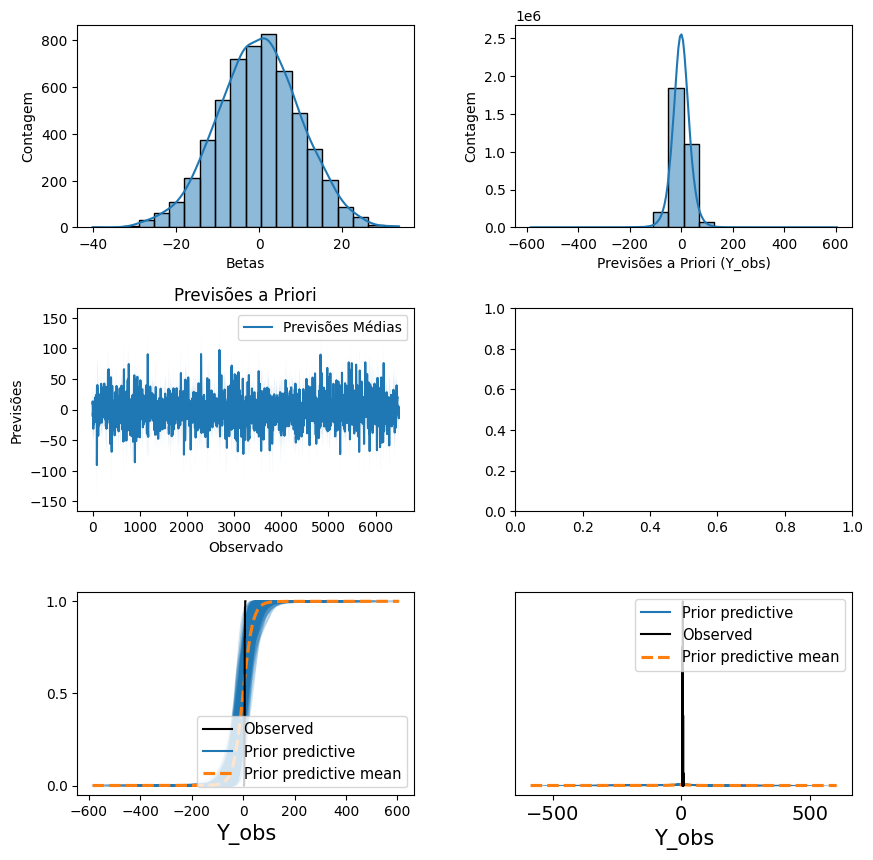

In [13]:
analise_priori(ridge_trace_prior, y)


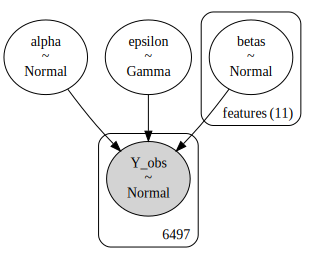

In [14]:
pm.model_to_graphviz(model_ridge)

In [15]:
def analise_posteriori(trace):
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  az.plot_ppc(trace, group='posterior', kind='cumulative', ax=axes[0]);
  az.plot_ppc(trace, group='posterior',ax=axes[1]);

  return fig, axes

Output()

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


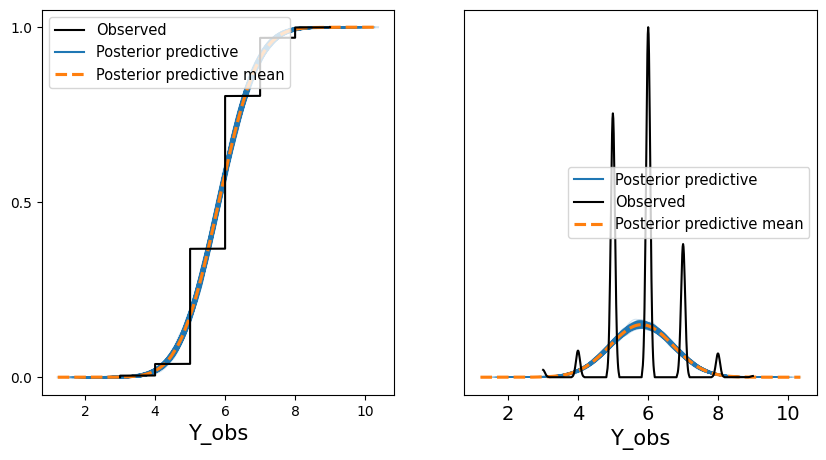

In [16]:

with model_ridge:
  trace_pos_ridge = pm.sample_posterior_predictive(trace_ridge)

analise_posteriori(trace_pos_ridge)


LASSO

In [17]:
import pymc as pm
import pytensor.tensor as pt  # Usar pytensor para a multiplicação de matrizes
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from math import sqrt

In [18]:
# Criar o modelo Lasso Bayesiano
with pm.Model(coords=coords) as model_lasso:
    # Priori para o intercepto (alpha)
    alpha = pm.Normal('alpha', mu=0, sigma=10)

    # Priori para os coeficientes de regressão (betas) com distribuição Laplace
    betas = pm.Laplace('betas', mu=0, b=1/sqrt(2), dims='features')  # b é o parâmetro de escala da Laplace

    # Priori para o desvio padrão do erro (epsilon)
    epsilon = pm.Gamma('epsilon', alpha=2, beta=1)

    # Definir a equação do modelo linear
    mu = alpha + pt.dot(X_scaled, betas)

    # Definir a verossimilhança (Normal)
    likelihood = pm.Normal('Y_obs', mu=mu, sigma=epsilon, observed=y)

    # Amostrar da distribuição a priori
    lasso_trace_prior = pm.sample_prior_predictive()

    # Amostrar da distribuição posterior
    trace_lasso = pm.sample(1000, tune=1000, target_accept=0.95)

# Exibir o resumo dos parâmetros ajustados

az.summary(trace_lasso)

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,5.819,0.009,5.802,5.835,0.000,0.000,2441.0,1543.0,1.0
betas[0],0.086,0.020,0.045,0.121,0.001,0.000,1140.0,1043.0,1.0
betas[1],-0.219,0.013,-0.244,-0.196,0.000,0.000,1660.0,1497.0,1.0
betas[2],-0.016,0.012,-0.039,0.005,0.000,0.000,1710.0,1374.0,1.0
betas[3],0.205,0.024,0.162,0.251,0.001,0.001,854.0,1146.0,1.0
betas[4],-0.017,0.012,-0.040,0.004,0.000,0.000,1732.0,1319.0,1.0
betas[5],0.106,0.013,0.081,0.129,0.000,0.000,1610.0,1368.0,1.0
betas[6],-0.140,0.015,-0.167,-0.111,0.000,0.000,1422.0,1422.0,1.0
betas[7],-0.161,0.036,-0.228,-0.097,0.001,0.001,799.0,1013.0,1.0
betas[8],0.070,0.015,0.040,0.096,0.000,0.000,1097.0,1260.0,1.0


<ipython-input-6-4581fe9e5373>:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


(<Figure size 1000x1000 with 6 Axes>,
 array([[<Axes: xlabel='Betas', ylabel='Contagem'>,
         <Axes: xlabel='Previsões a Priori (Y_obs)', ylabel='Contagem'>],
        [<Axes: title={'center': 'Previsões a Priori'}, xlabel='Observado', ylabel='Previsões'>,
         <Axes: >],
        [<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>]], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


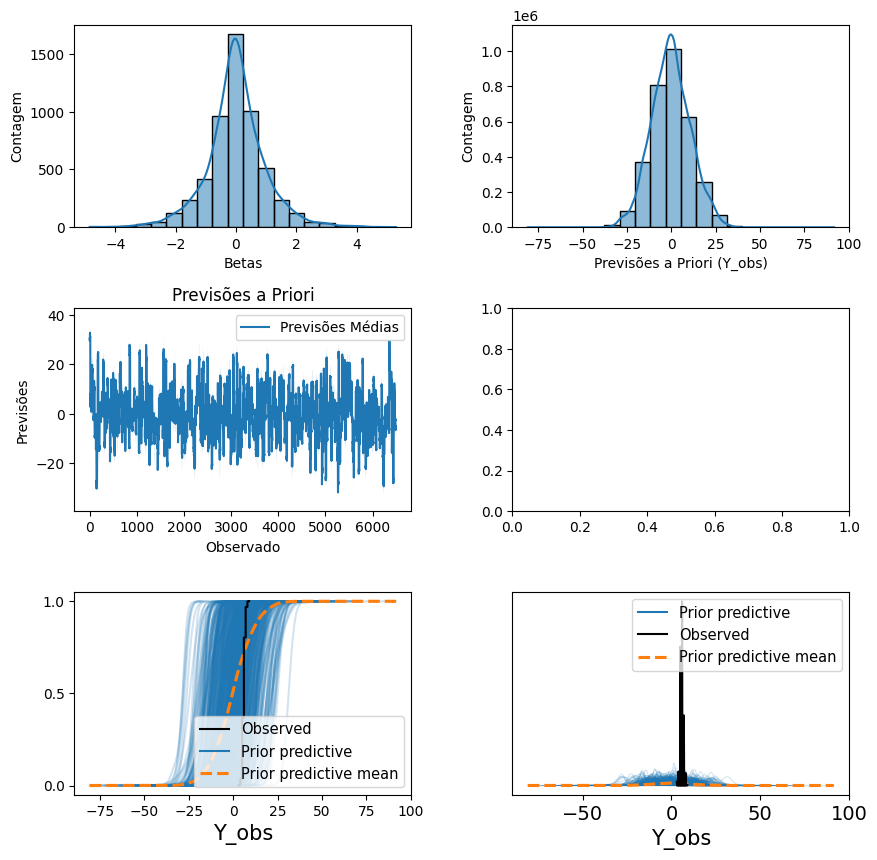

In [19]:
# Supondo que 'y' é seu vetor de dados observados
analise_priori(lasso_trace_prior, y)

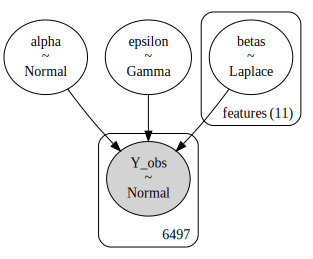

In [20]:

pm.model_to_graphviz(model_lasso)

Output()

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


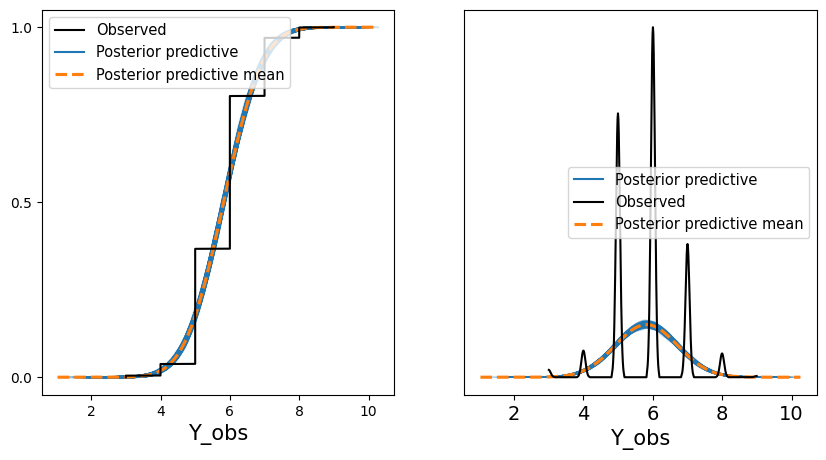

In [21]:
with model_lasso:
  trace_pos_lasso = pm.sample_posterior_predictive(trace_lasso)

analise_posteriori(trace_pos_lasso)

HIERARQUICO

In [22]:
# Criar o modelo Bayesiano Hierárquico
with pm.Model(coords=coords) as model_hierarchical:
    # Priori para o intercepto (alpha)
    alpha = pm.Normal('alpha', mu=0, sigma=10)

    # Priori hiperparamétrica para o desvio padrão das Laplaces dos betas
    b_hyper = pm.Gamma('b_hyper', alpha=2, beta=1)

    # Priori hierárquica para os coeficientes de regressão (betas) com distribuição Laplace
    betas = pm.Laplace('betas', mu=0, b=b_hyper, dims='features')

    # Priori hiperparamétrica para o desvio padrão do erro (epsilon)
    epsilon_hyper = pm.Gamma('epsilon_hyper', alpha=2, beta=1)
    epsilon = pm.HalfNormal('epsilon', sigma=epsilon_hyper)

    # Definir a equação do modelo linear
    mu = alpha + pt.dot(X_scaled, betas)

    # Definir a verossimilhança (Normal)
    likelihood = pm.Normal('Y_obs', mu=mu, sigma=epsilon, observed=y)

    # Amostrar da distribuição a priori
    trace_prior_hierarchical = pm.sample_prior_predictive()

    # Amostrar da distribuição posterior
    trace_hierarchical = pm.sample(1000, tune=1000, target_accept=0.95)

    # Calcular log_likelihood
    pm.compute_log_likelihood(trace_hierarchical)

# Exibir o resumo dos parâmetros ajustados

az.summary(trace_hierarchical)


Output()

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,5.818,0.009,5.801,5.834,0.000,0.000,2002.0,1368.0,1.00
b_hyper,0.170,0.060,0.073,0.280,0.001,0.001,2102.0,1365.0,1.00
betas[0],0.079,0.021,0.042,0.119,0.001,0.001,754.0,985.0,1.01
betas[1],-0.219,0.013,-0.242,-0.193,0.000,0.000,1433.0,1394.0,1.00
betas[2],-0.015,0.012,-0.038,0.005,0.000,0.000,1807.0,1568.0,1.00
betas[3],0.196,0.025,0.150,0.244,0.001,0.001,766.0,962.0,1.00
betas[4],-0.018,0.012,-0.039,0.005,0.000,0.000,2091.0,1443.0,1.00
betas[5],0.104,0.014,0.077,0.130,0.000,0.000,1878.0,1255.0,1.00
betas[6],-0.137,0.015,-0.164,-0.108,0.000,0.000,1565.0,1421.0,1.00
betas[7],-0.148,0.037,-0.212,-0.074,0.001,0.001,644.0,759.0,1.00


<ipython-input-6-4581fe9e5373>:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


(<Figure size 1000x1000 with 6 Axes>,
 array([[<Axes: xlabel='Betas', ylabel='Contagem'>,
         <Axes: xlabel='Previsões a Priori (Y_obs)', ylabel='Contagem'>],
        [<Axes: title={'center': 'Previsões a Priori'}, xlabel='Observado', ylabel='Previsões'>,
         <Axes: >],
        [<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>]], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


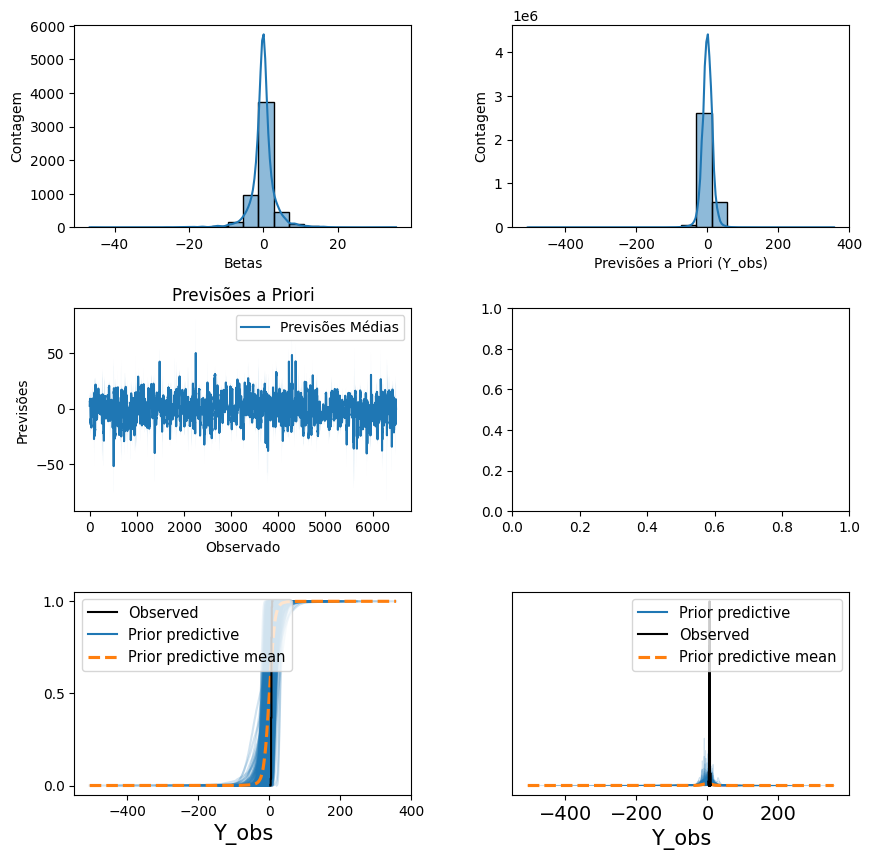

In [23]:

analise_priori(trace_prior_hierarchical,y)

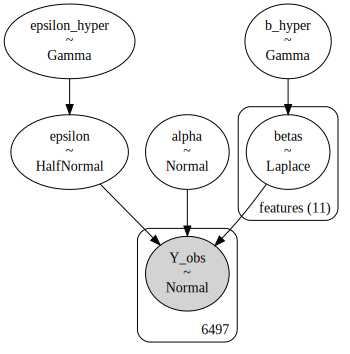

In [24]:
pm.model_to_graphviz(model_hierarchical)

Output()

<Axes: xlabel='Y_obs'>

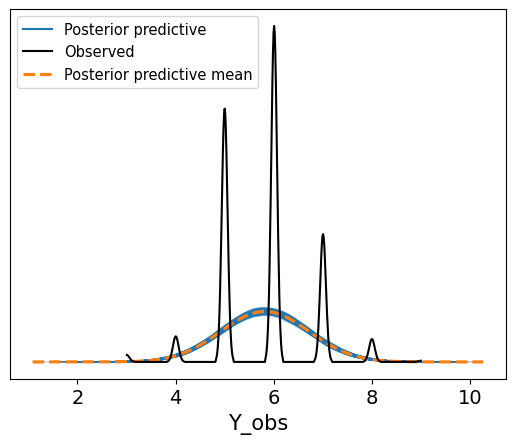

In [25]:
with model_hierarchical:
  trace_pos_hierarc = pm.sample_posterior_predictive(trace_hierarchical)


# Agora, passe o posterior_predictive para a função de análise posterior
az.plot_ppc(posterior_predictive, data_pairs={"Y_obs": "Y_obs"})

ROBUSTO

In [26]:
# Criar o modelo Bayesiano Robusto
with pm.Model(coords=coords) as model_robust:
    # Priori para o intercepto (alpha)
    alpha = pm.Normal('alpha', 0, 1)

    # Priori para os coeficientes de regressão (betas)
    betas = pm.Normal('betas', 0, 1, dims='features')

    # Priori para os graus de liberdade da distribuição Student-T (df)
    df = pm.Exponential('df', 1)

    # Definir a equação do modelo linear
    mu = alpha + pt.dot(X_scaled, betas)

    # Definir a verossimilhança com distribuição Student-T
    likelihood = pm.StudentT('Y_obs', nu=df, mu=mu, observed=y)

    # Amostrar da distribuição a priori
    robust_trace_prior = pm.sample_prior_predictive()

    # Amostrar da distribuição posterior
    trace_robust = pm.sample(1000, tune=1000, target_accept=0.95)

# Exibir o resumo dos parâmetros ajustados

az.summary(trace_robust)

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,5.817,0.013,5.795,5.842,0.000,0.000,2053.0,1513.0,1.0
betas[0],0.091,0.028,0.043,0.144,0.001,0.001,923.0,1092.0,1.0
betas[1],-0.217,0.017,-0.251,-0.186,0.000,0.000,1392.0,1313.0,1.0
betas[2],-0.016,0.015,-0.044,0.012,0.000,0.000,1692.0,1260.0,1.0
betas[3],0.209,0.034,0.147,0.271,0.001,0.001,794.0,1051.0,1.0
betas[4],-0.017,0.016,-0.046,0.015,0.000,0.000,2020.0,1460.0,1.0
betas[5],0.110,0.018,0.075,0.144,0.000,0.000,1426.0,1289.0,1.0
betas[6],-0.142,0.021,-0.183,-0.104,0.001,0.000,1401.0,1602.0,1.0
betas[7],-0.170,0.050,-0.261,-0.076,0.002,0.001,675.0,938.0,1.0
betas[8],0.072,0.020,0.035,0.109,0.001,0.000,1039.0,1483.0,1.0


/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:250: RuntimeWarning: divide by zero encountered in scalar power
  out = t - (2 * N * np.pi**0.5 * f) ** (-0.4)
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:246: RuntimeWarning: divide by zero encountered in scalar divide
  t_j = np.power((c1 * (c2 / (N * f))), (2.0 / (3.0 + 2.0 * j)))
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
<ipython-input-27-be4523a56207>:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


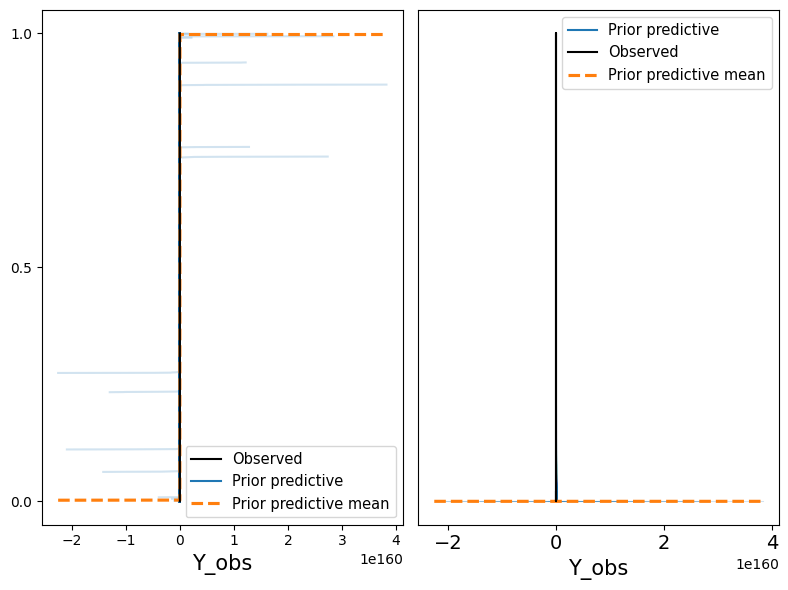

In [27]:
# Criar subplots para exibir os gráficos
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

# Plotar o Posterior Predictive Check cumulativo e regular
az.plot_ppc(robust_trace_prior, group='prior', kind='cumulative', ax=axes[0], observed=True)
az.plot_ppc(robust_trace_prior, group='prior', ax=axes[1], observed=True)

# Ajustar layout
plt.tight_layout()
plt.show()

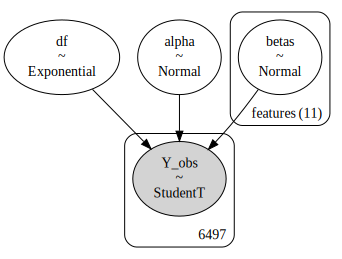

In [28]:
pm.model_to_graphviz(model_robust)

Output()

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: xlabel='Y_obs'>, <Axes: xlabel='Y_obs'>], dtype=object))

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


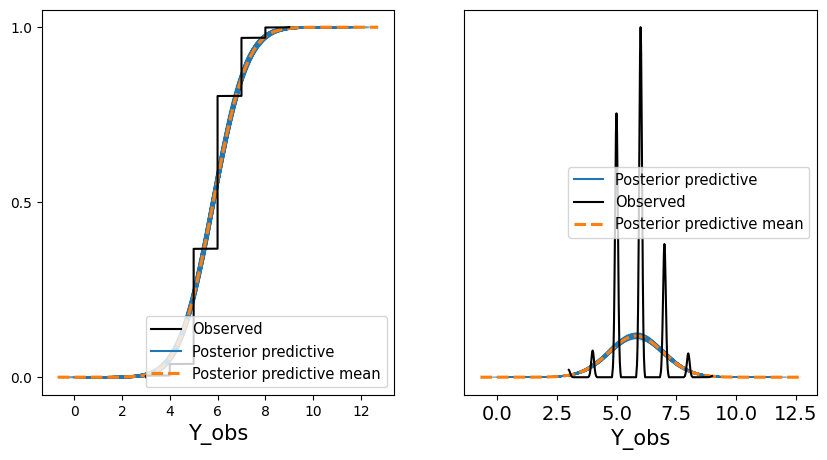

In [29]:
with model_robust:
  trace_pos_robust = pm.sample_posterior_predictive(trace_robust)

analise_posteriori(trace_pos_robust)

COMPARANDO MODELOS

In [31]:
# Verificar se o log_likelihood já existe antes de recalcular
if 'log_likelihood' not in trace_ridge.groups():
    with model_ridge:
        pm.compute_log_likelihood(trace_ridge)


if 'log_likelihood' not in trace_lasso.groups():
    with model_lasso:
        pm.compute_log_likelihood(trace_lasso)

if 'log_likelihood' not in trace_hierarchical.groups():
    with model_hierarchical:
        pm.compute_log_likelihood(trace_robust)

if 'log_likelihood' not in trace_robust.groups():
    with model_robust:
        pm.compute_log_likelihood(trace_robust)

Output()

In [32]:
# Verifique se o log_likelihood foi corretamente adicionado
print(trace_ridge.groups())

print(trace_lasso.groups())

print(trace_robust.groups())

print(trace_hierarchical.groups())

['posterior', 'log_likelihood', 'sample_stats', 'observed_data']
['posterior', 'log_likelihood', 'sample_stats', 'observed_data']
['posterior', 'log_likelihood', 'sample_stats', 'observed_data']
['posterior', 'log_likelihood', 'sample_stats', 'observed_data']


In [ ]:
# Amostragem para o modelo Lasso
with model_lasso:
    trace_lasso = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)
    # Incluindo o cálculo do log likelihood
    trace_lasso = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)

# Amostragem para o modelo Hierárquico
with model_hierarchical:
    trace_hierarchical = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)

# Amostragem para o modelo Robusto
with model_robust:
    trace_robust = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)

# Amostragem para o modelo Ridge
with model_ridge:
    trace_ridge = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)


Output()

In [ ]:
import arviz as az
import matplotlib.pyplot as plt


In [ ]:
# Comparar os modelos com base no LOO (Leave-One-Out Cross-Validation)
comparison = az.compare({
    'Lasso': trace_lasso,
    'Hierarchical': trace_hierarchical,
    'Robust': trace_robust,
    'Ridge': trace_ridge
}, method='LOO')


In [ ]:
# Plotar a comparação dos modelos
az.plot_compare(comparison)
plt.show()
